In [1]:
# import relevant packages
import scipy.signal as ssig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# [pd.read_csv(video_path+'/'+file_name) for file_name in file_names][0][['DLC_resnet50_minimal-lip-readingNov19shuffle1_20000.7', 'DLC_resnet50_minimal-lip-readingNov19shuffle1_20000.10']]

In [3]:
# get path files
video_path = "/Users/quinnwaiwong/projects/lip_reading/2-4-21-data"
# file_names = !cd "/Volumes/BIG BOI/Research/words_only_avi"; find *.csv

# df_videos = [pd.read_csv(video_path+'/'+file_name, header=[1,2]) for file_name in file_names]

file_names = !cd "/Users/quinnwaiwong/projects/lip_reading/2-4-21-data"; find *.h5
df_videos = [pd.read_hdf(video_path+'/'+file_name).droplevel(level=0,axis=1) for file_name in file_names]

assert len(file_names) == len(df_videos), "could not upload all videos"

In [4]:
# list of words associated with each file name
words = [file.split(' ')[0] for file in file_names]
words

['Fill',
 'Film',
 'Find',
 'Fine',
 'Flea',
 'Fleet',
 'Leader',
 'Leather',
 'Less',
 'Liar',
 'Locker',
 'Ocean',
 'Open',
 'Oven',
 'Shadow',
 'Shallow']

Visualizing data below, you can see that columns have multiple indices, accesible as ("Title", "Subtitle")

In [5]:
df_videos[0].head()

bodyparts  leftCorner                        rightCorner              \
coords              x           y likelihood           x           y   
0          356.233124  269.419067   0.999996  410.383453  264.216278   
1          356.233124  269.419067   0.999996  410.383453  264.216278   
2          356.233124  269.419067   0.999996  410.383453  264.216278   
3          356.233124  269.419067   0.999996  410.383453  264.216278   
4          356.233124  269.419067   0.999996  410.383453  264.216278   

bodyparts                 topLip                          bottomLip  ...  \
coords    likelihood           x           y likelihood           x  ...   
0           0.999991  385.635437  253.604446   0.999995  385.857452  ...   
1           0.999991  385.635437  253.604446   0.999995  385.857452  ...   
2           0.999991  385.635437  253.604446   0.999995  385.857452  ...   
3           0.999991  385.635437  253.604446   0.999995  385.857452  ...   
4           0.999991  385.635437  253.604446   0.999995  385.857452  ...   

bodyparts bottomTeeth      tongue                           topLipLo  \
coords     likelihood           x           y likelihood           x   
0            0.756491  383.875916  267.207977   0.350048  386.023895   
1            0.756491  383.875916  267.207977   0.350048  386.023895   
2            0.756491  383.875916  267.207977   0.350048  386.023895   
3            0.756491  383.875916  267.207977   0.350048  386.023895   
4            0.756491  383.875916  267.207977   0.350048  386.023895   

bodyparts                        bottomLipHi                         
coords              y likelihood           x           y likelihood  
0          259.620392   0.999996   384.84079  271.208923   0.999993  
1          259.620392   0.999996   384.84079  271.208923   0.999993  
2          259.620392   0.999996   384.84079  271.208923   0.999993  
3          259.620392   0.999996   384.84079  271.208923   0.999993  
4          259.620392   0.999996   384.84079  271.208923   0.999993  

[5 rows x 27 columns]

In [6]:
df_videos[0].columns

MultiIndex([( 'leftCorner',          'x'),
            ( 'leftCorner',          'y'),
            ( 'leftCorner', 'likelihood'),
            ('rightCorner',          'x'),
            ('rightCorner',          'y'),
            ('rightCorner', 'likelihood'),
            (     'topLip',          'x'),
            (     'topLip',          'y'),
            (     'topLip', 'likelihood'),
            (  'bottomLip',          'x'),
            (  'bottomLip',          'y'),
            (  'bottomLip', 'likelihood'),
            (   'topTeeth',          'x'),
            (   'topTeeth',          'y'),
            (   'topTeeth', 'likelihood'),
            ('bottomTeeth',          'x'),
            ('bottomTeeth',          'y'),
            ('bottomTeeth', 'likelihood'),
            (     'tongue',          'x'),
            (     'tongue',          'y'),
            (     'tongue', 'likelihood'),
            (   'topLipLo',          'x'),
            (   'topLipLo',          'y'),
           

In [7]:
df_videos[0][[('bottomLip','y'),('topLip','y')]]

bodyparts,bottomLip,topLip
coords,y,y
0,278.869781,253.604446
1,278.869781,253.604446
2,278.869781,253.604446
3,278.869781,253.604446
4,278.869781,253.604446
...,...,...
61,278.476227,258.666260
62,278.316010,258.763458
63,278.164276,258.858582


In [8]:
# calculates area for a polygon given points 
# SOURCE: https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
def PolyArea(x,y):
    """ Calculates the area of a 2D polygon enclosed by coordinates specified by (x[i], y[i]) for i from 0 to len(x)
    """
    
    assert len(x) == len(y), "x and y are not the same length"
    
    # TODO: find way to make sure coordinates don't cross each other?
    
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [9]:
# separate data into x and y coor (note: assumes that points are in order of the going around a polygon)
x = np.array([4,5,2,3])
y = np.array([3,1,1,3])

PolyArea(x,y)

4.0

In [10]:
# calculating area test
# validated area works using https://www.mathopenref.com/coordpolygonareacalc.html 
# Notice that 0 of the y coordinate starts at the top border of the video so topLip is a low value than bottomLip
test = df_videos[0]

pts = ["bottomLipHi", "leftCorner", "topLipLo", "rightCorner"]
x_cols = [(pt,'x') for pt in pts]
y_cols = [(pt,'y') for pt in pts]


x_coord = np.array([test.iloc[0][col] for col in x_cols])
y_coord = np.array([test.iloc[0][col] for col in y_cols])

print(pts)
print(f'x: {x_coord}')
print(f'y: {y_coord}')
print(f'Area: {PolyArea(x_coord,y_coord)}')

['bottomLipHi', 'leftCorner', 'topLipLo', 'rightCorner']
x: [384.84078979 356.23312378 386.02389526 410.38345337]
y: [271.20892334 269.41906738 259.62039185 264.21627808]
Area: 310.6836756942794


In [11]:
x_coords = np.array([test.iloc[i][x_cols] for i in range(len(test))])
y_coords = np.array([test.iloc[i][y_cols] for i in range(len(test))])

# assert thing.shape == (len(test),len(x_cols)), "wrong shape"

areas = [PolyArea(x_coords[i],y_coords[i]) for i in range(len(x_coords))]
areas[0:10]

[310.6836756942794,
 310.6836756942794,
 310.6836756942794,
 310.6836756942794,
 310.6836756942794,
 310.6836756942794,
 310.6836756942794,
 310.6836756942794,
 308.7984172133729,
 302.36905922042206]

In [12]:
# to show that the first noticeable change is from the 9th to the 10th frame (see topLip x and bottomLip y)
test.iloc[0:10][x_cols + y_cols]

bodyparts,bottomLipHi,leftCorner,topLipLo,rightCorner,bottomLipHi,leftCorner,topLipLo,rightCorner
coords,x,x,x,x,y,y,y,y
0,384.840790,356.233124,386.023895,410.383453,271.208923,269.419067,259.620392,264.216278
1,384.840790,356.233124,386.023895,410.383453,271.208923,269.419067,259.620392,264.216278
2,384.840790,356.233124,386.023895,410.383453,271.208923,269.419067,259.620392,264.216278
3,384.840790,356.233124,386.023895,410.383453,271.208923,269.419067,259.620392,264.216278
4,384.840790,356.233124,386.023895,410.383453,271.208923,269.419067,259.620392,264.216278
5,384.840790,356.233124,386.023895,410.383453,271.208923,269.419067,259.620392,264.216278
6,384.840790,356.233124,386.023895,410.383453,271.208923,269.419067,259.620392,264.216278
7,384.840790,356.233124,386.023895,410.383453,271.208923,269.419067,259.620392,264.216278
8,384.743988,356.439056,385.997437,410.236481,271.394989,269.516083,259.795654,264.396210


In [13]:
# to show that from above, the change in distances are
print(x_coords[8]-x_coords[7])
print(y_coords[8]-y_coords[7])

[-0.09680176  0.20593262 -0.02645874 -0.14697266]
[0.18606567 0.09701538 0.17526245 0.17993164]


In [14]:
# creating new column for dataset
# TODO: add an assert for when the points cross each other (corners cross x-wise and lips cross y-wise)
# TODO: do this for all data frames not just test which is df_videos[0]
df_videos[0][('mouthArea')]=areas
df_videos[0][0:10]

bodyparts  leftCorner                        rightCorner              \
coords              x           y likelihood           x           y   
0          356.233124  269.419067   0.999996  410.383453  264.216278   
1          356.233124  269.419067   0.999996  410.383453  264.216278   
2          356.233124  269.419067   0.999996  410.383453  264.216278   
3          356.233124  269.419067   0.999996  410.383453  264.216278   
4          356.233124  269.419067   0.999996  410.383453  264.216278   
5          356.233124  269.419067   0.999996  410.383453  264.216278   
6          356.233124  269.419067   0.999996  410.383453  264.216278   
7          356.233124  269.419067   0.999996  410.383453  264.216278   
8          356.439056  269.516083   0.999996  410.236481  264.396210   
9          356.507263  269.610382   0.999996  410.145752  264.544739   

bodyparts                 topLip                          bottomLip  ...  \
coords    likelihood           x           y likelihood           x  ...   
0           0.999991  385.635437  253.604446   0.999995  385.857452  ...   
1           0.999991  385.635437  253.604446   0.999995  385.857452  ...   
2           0.999991  385.635437  253.604446   0.999995  385.857452  ...   
3           0.999991  385.635437  253.604446   0.999995  385.857452  ...   
4           0.999991  385.635437  253.604446   0.999995  385.857452  ...   
5           0.999991  385.635437  253.604446   0.999995  385.857452  ...   
6           0.999991  385.635437  253.604446   0.999995  385.857452  ...   
7           0.999991  385.635437  253.604446   0.999995  385.857452  ...   
8           0.999991  385.631500  253.700943   0.999995  385.789703  ...   
9           0.999989  385.515289  253.654266   0.999995  385.800873  ...   

bodyparts      tongue                           topLipLo              \
coords              x           y likelihood           x           y   
0          383.875916  267.207977   0.350048  386.023895  259.620392   
1          383.875916  267.207977   0.350048  386.023895  259.620392   
2          383.875916  267.207977   0.350048  386.023895  259.620392   
3          383.875916  267.207977   0.350048  386.023895  259.620392   
4          383.875916  267.207977   0.350048  386.023895  259.620392   
5          383.875916  267.207977   0.350048  386.023895  259.620392   
6          383.875916  267.207977   0.350048  386.023895  259.620392   
7          383.875916  267.207977   0.350048  386.023895  259.620392   
8          385.385315  267.758331   0.379870  385.997437  259.795654   
9          385.423157  267.806488   0.341568  385.900635  259.688477   

bodyparts            bottomLipHi                          mouthArea  
coords    likelihood           x           y likelihood              
0           0.999996  384.840790  271.208923   0.999993  310.683676  
1           0.999996  384.840790  271.208923   0.999993  310.683676  
2           0.999996  384.840790  271.208923   0.999993  310.683676  
3           0.999996  384.840790  271.208923   0.999993  310.683676  
4           0.999996  384.840790  271.208923   0.999993  310.683676  
5           0.999996  384.840790  271.208923   0.999993  310.683676  
6           0.999996  384.840790  271.208923   0.999993  310.683676  
7           0.999996  384.840790  271.208923   0.999993  310.683676  
8           0.999996  384.743988  271.394989   0.999992  308.798417  
9           0.999996  384.724823  271.073853   0.999993  302.369059  

[10 rows x 28 columns]

In [15]:
df_videos[0].head()

bodyparts  leftCorner                        rightCorner              \
coords              x           y likelihood           x           y   
0          356.233124  269.419067   0.999996  410.383453  264.216278   
1          356.233124  269.419067   0.999996  410.383453  264.216278   
2          356.233124  269.419067   0.999996  410.383453  264.216278   
3          356.233124  269.419067   0.999996  410.383453  264.216278   
4          356.233124  269.419067   0.999996  410.383453  264.216278   

bodyparts                 topLip                          bottomLip  ...  \
coords    likelihood           x           y likelihood           x  ...   
0           0.999991  385.635437  253.604446   0.999995  385.857452  ...   
1           0.999991  385.635437  253.604446   0.999995  385.857452  ...   
2           0.999991  385.635437  253.604446   0.999995  385.857452  ...   
3           0.999991  385.635437  253.604446   0.999995  385.857452  ...   
4           0.999991  385.635437  253.604446   0.999995  385.857452  ...   

bodyparts      tongue                           topLipLo              \
coords              x           y likelihood           x           y   
0          383.875916  267.207977   0.350048  386.023895  259.620392   
1          383.875916  267.207977   0.350048  386.023895  259.620392   
2          383.875916  267.207977   0.350048  386.023895  259.620392   
3          383.875916  267.207977   0.350048  386.023895  259.620392   
4          383.875916  267.207977   0.350048  386.023895  259.620392   

bodyparts            bottomLipHi                          mouthArea  
coords    likelihood           x           y likelihood              
0           0.999996   384.84079  271.208923   0.999993  310.683676  
1           0.999996   384.84079  271.208923   0.999993  310.683676  
2           0.999996   384.84079  271.208923   0.999993  310.683676  
3           0.999996   384.84079  271.208923   0.999993  310.683676  
4           0.999996   384.84079  271.208923   0.999993  310.683676  

[5 rows x 28 columns]

In [16]:
def appendPolyArea(df):
    pts = ["bottomLipHi", "leftCorner", "topLipLo", "rightCorner"]
    x_cols = [(pt,'x') for pt in pts]
    y_cols = [(pt,'y') for pt in pts]
    
    x_coords = np.array([df.iloc[i][x_cols] for i in range(len(df))])
    y_coords = np.array([df.iloc[i][y_cols] for i in range(len(df))])

    areas = [PolyArea(x_coords[i],y_coords[i]) for i in range(len(x_coords))]
    return areas

In [17]:
def appendIndicatorVariables(df, colName):
    col = df[(colName, "likelihood")]
    stats = df[(colName, "likelihood")].describe()
    threshold = stats['50%']
    return (col >= threshold).astype(int)

In [18]:
def appendMouthShape(df):
    # should word comparisons
    x_diff = abs(df[("rightCorner", "x")]-df[("leftCorner", "x")])
    y_diff = abs(df[("bottomLip", "y")]-df[("topLip", "y")]) # (bottom-top) because y axis indexes the top as 0
    return y_diff/x_diff

In [19]:
df_new_features = [0 for i in range(len(df_videos))]

for i in range(len(df_videos)):
    df_dict = {}
    df = df_videos[i]
    
    df_dict["MouthArea"] = appendPolyArea(df)
    df_dict["HasTopTeeth"] = appendIndicatorVariables(df, "topTeeth")
    df_dict["HasBottomTeeth"] = appendIndicatorVariables(df, "bottomTeeth")
    df_dict["HasTongue"] = appendIndicatorVariables(df, "tongue")
    df_dict["MouthShape"] = appendMouthShape(df)

    df_new_features[i] = pd.DataFrame(df_dict)

In [20]:
df_new_features[-1]

,MouthArea,HasTopTeeth,HasBottomTeeth,HasTongue,MouthShape
0,380.448371,1,1,1,0.469380
1,380.448371,1,1,1,0.469380
2,380.448371,1,1,1,0.469380
3,380.448371,1,1,1,0.469380
4,380.448371,1,1,1,0.469380
...,...,...,...,...,...
61,158.832215,0,0,0,0.359923
62,134.309679,0,0,0,0.349764
63,126.959283,0,0,0,0.347162
64,110.702108,0,0,0,0.343016


Plots by word for each feature

In [21]:
def plotFeature(features, dfs, words, ylo, yhi, save_path=None):
    """
    Creates feature plots for all

    Parameters
    ----------
    columns : iter
        names of features to process
    dfs : iter[DataFrames]
        list of DataFrames to process
    words : iter
        list of words associated with each DataFrame
    ylo : int
        lower bound for y axis
    yhi : int
        upper bound for y axis
    Returns
    -------
    None
    """
    for feature in features:
        for i in range(len(dfs)):
            df = dfs[i]
            plt.figure()
            plt.scatter(range(len(df)), df[feature])
            plt.title(f"{feature} Feature for '{words[i]}'")
            plt.xlabel("Time")
            plt.ylabel("Values")
            plt.ylim(ylo, yhi)
            
            if save_path is not None: plt.savefig(f"{save_path}{words[i]}_{feature}.png", bbox_inches='tight')
    
    
    plt.show()


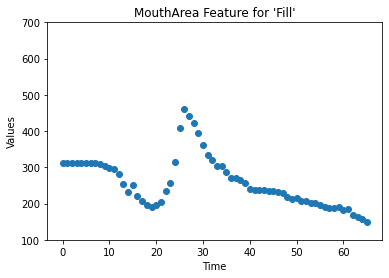

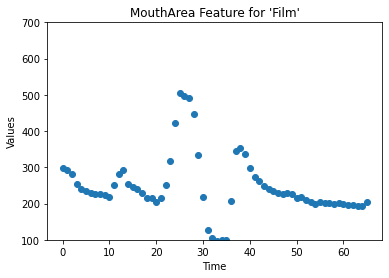

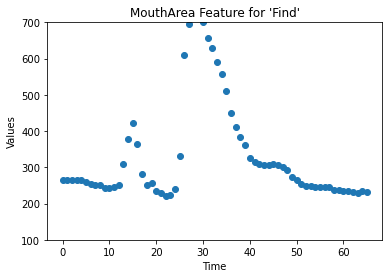

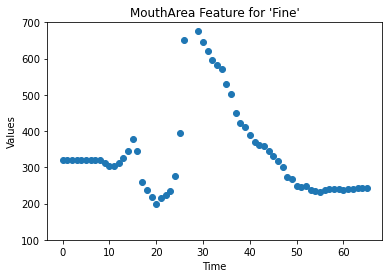

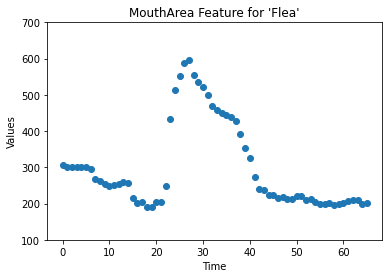

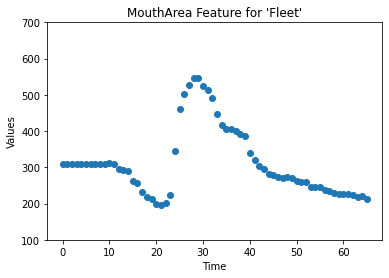

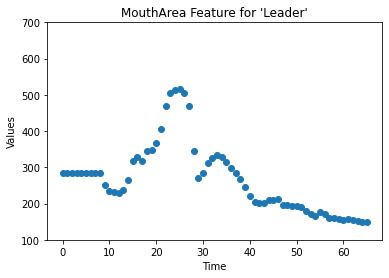

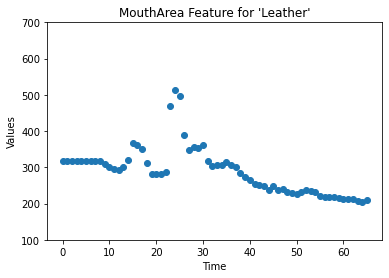

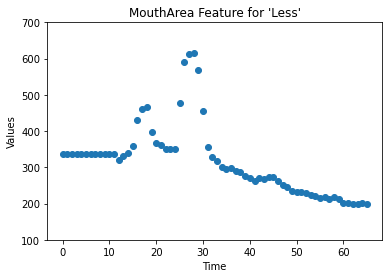

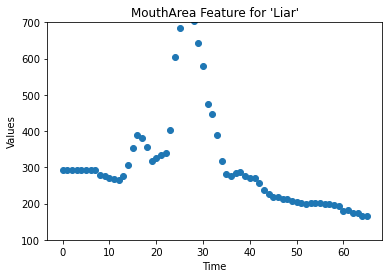

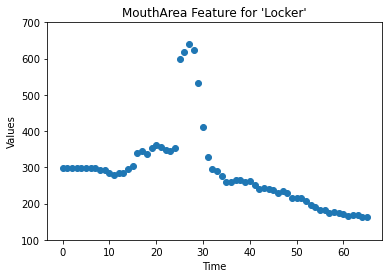

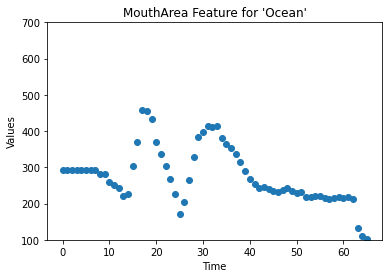

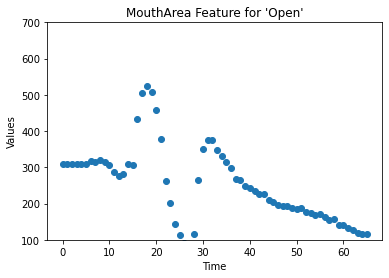

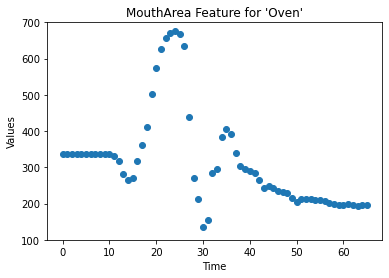

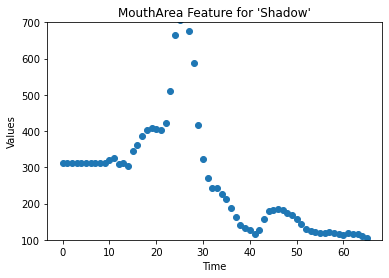

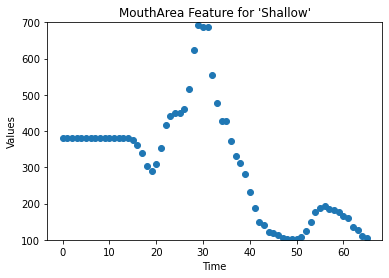

In [22]:
plotFeature(["MouthArea"], df_new_features, words, 100,700, save_path = "./figures/")

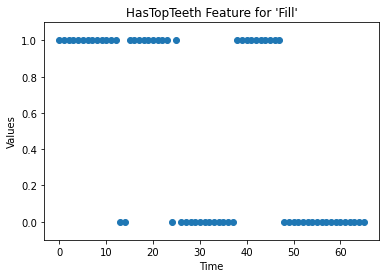

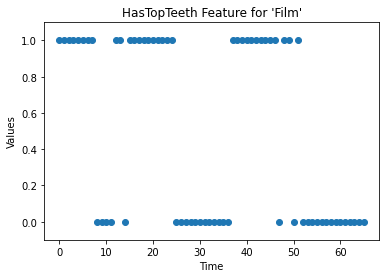

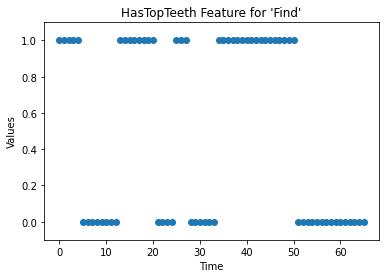

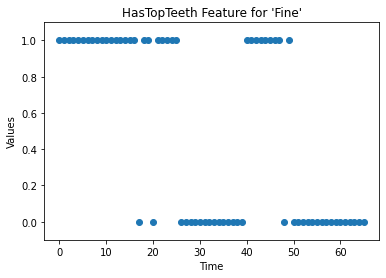

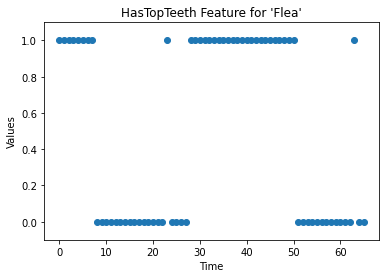

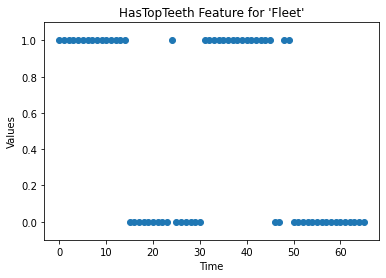

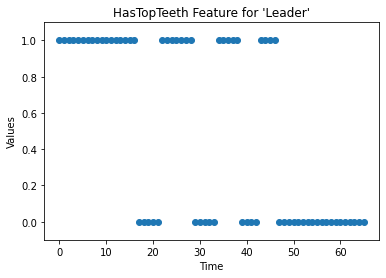

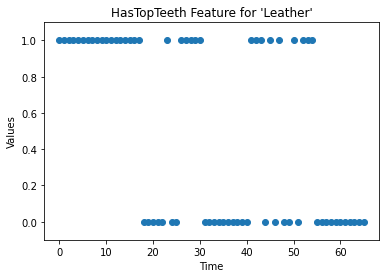

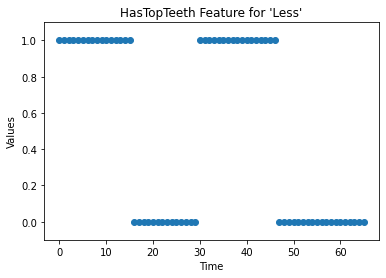

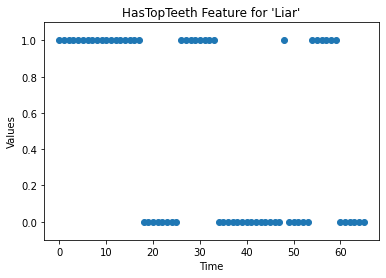

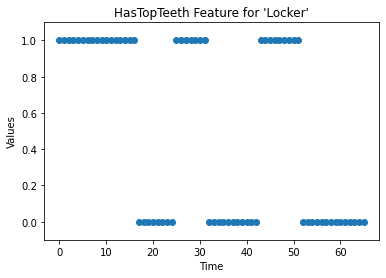

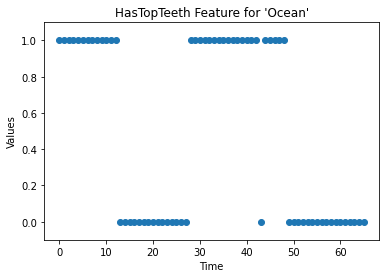

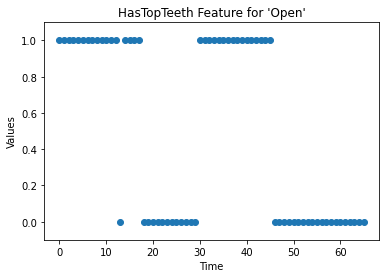

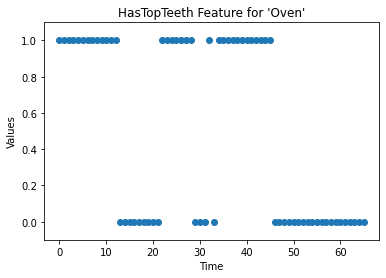

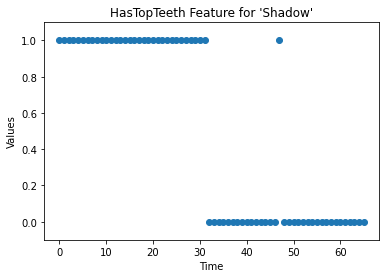

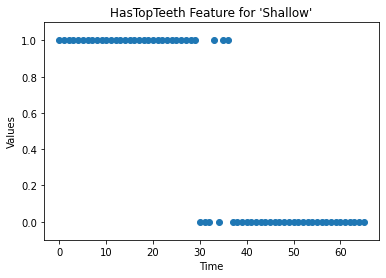

In [23]:
plotFeature(["HasTopTeeth"],df_new_features, words, -0.1,1.1)

/Users/quinnwaiwong/opt/anaconda3/envs/cse217a/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


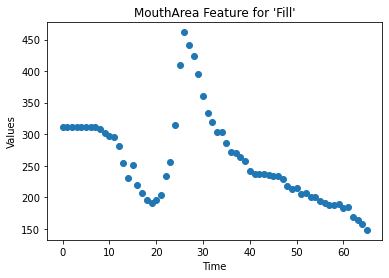

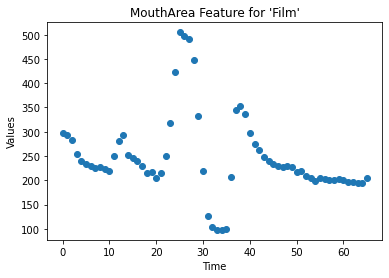

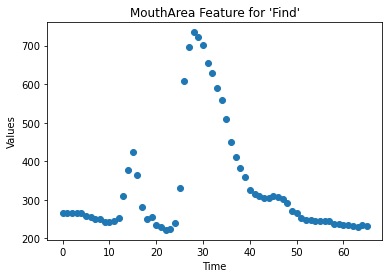

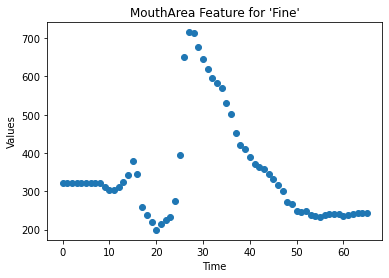

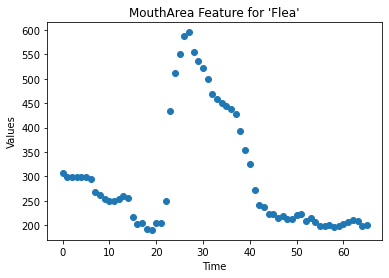

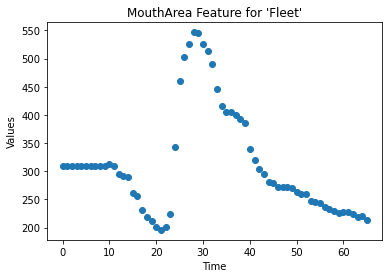

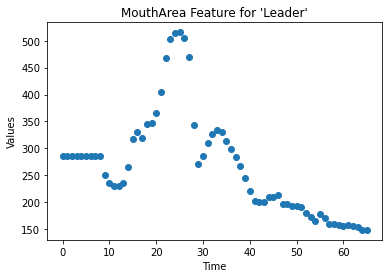

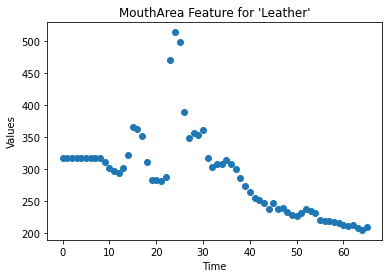

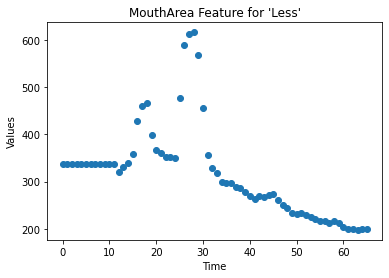

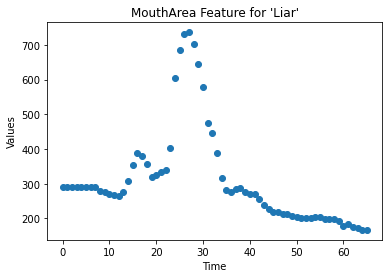

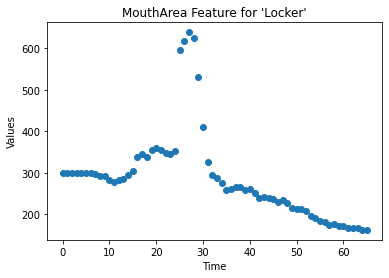

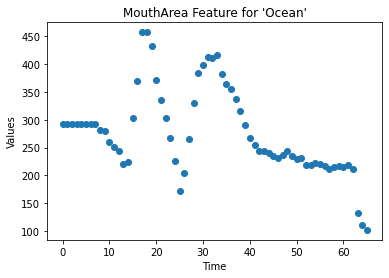

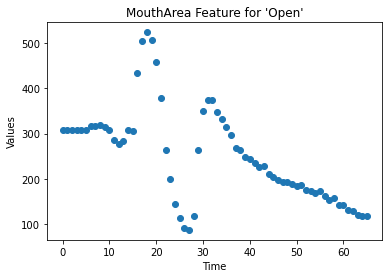

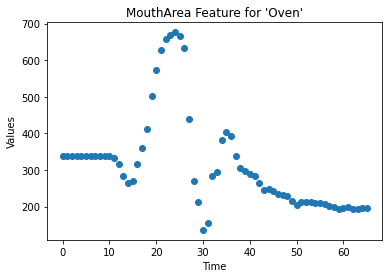

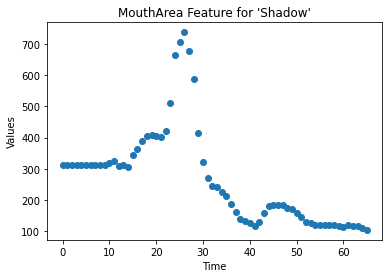

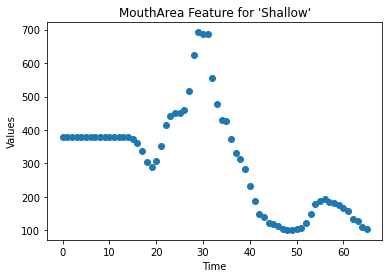

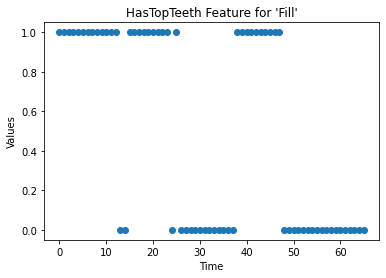

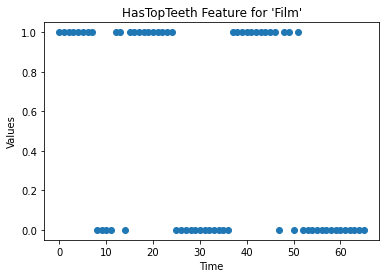

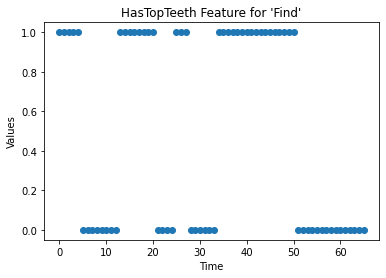

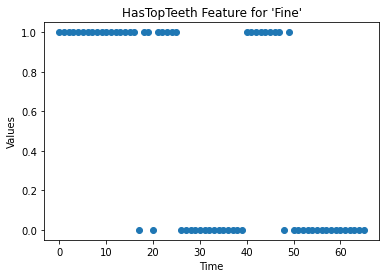

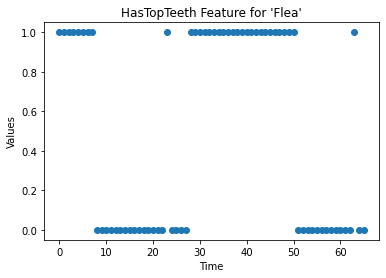

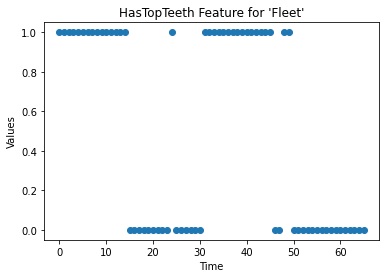

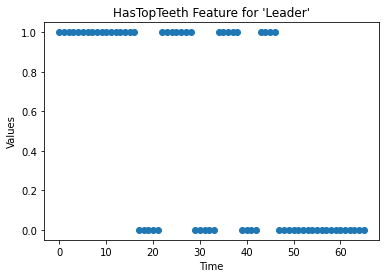

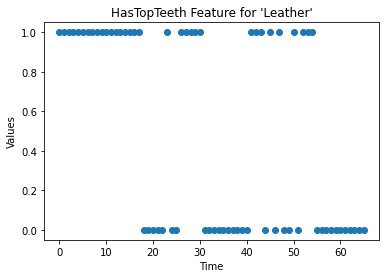

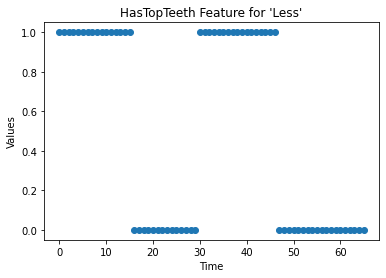

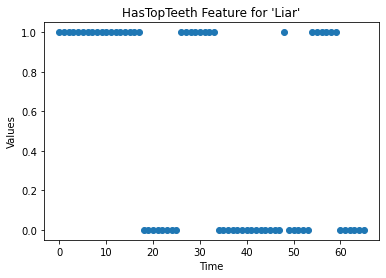

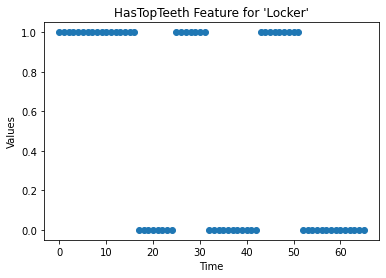

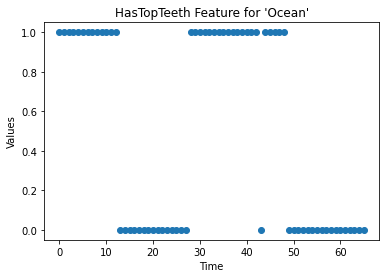

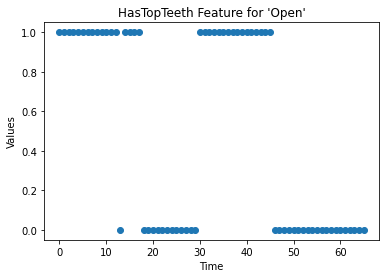

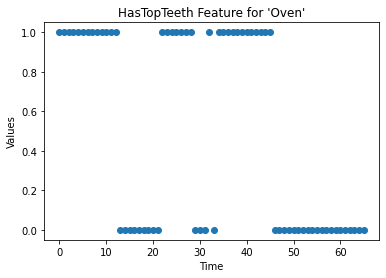

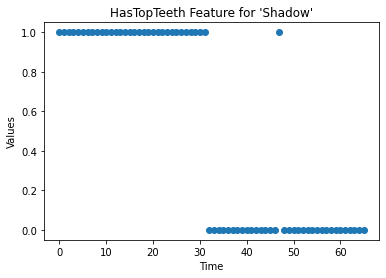

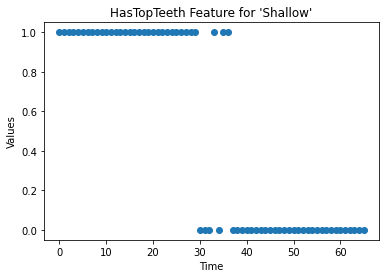

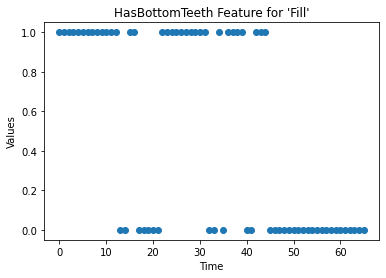

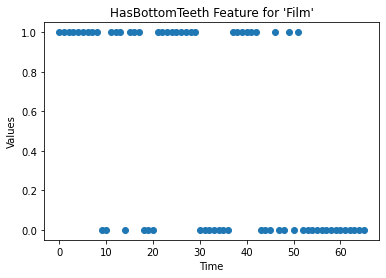

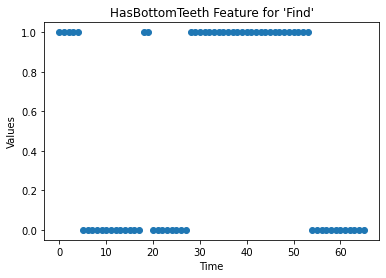

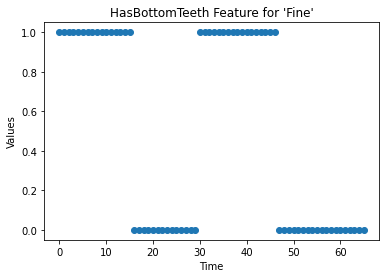

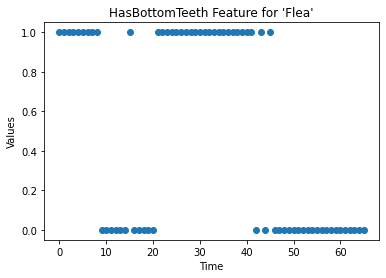

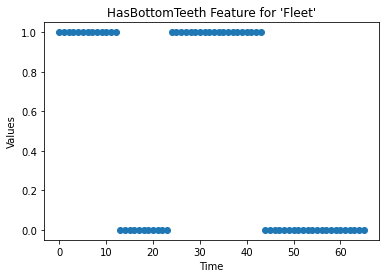

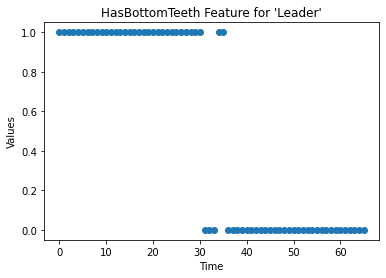

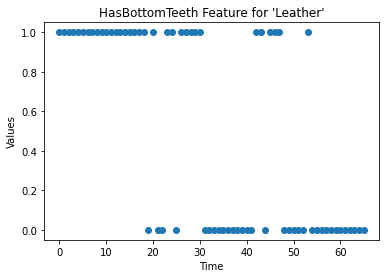

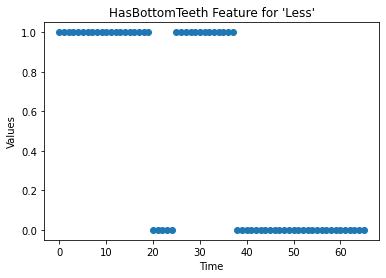

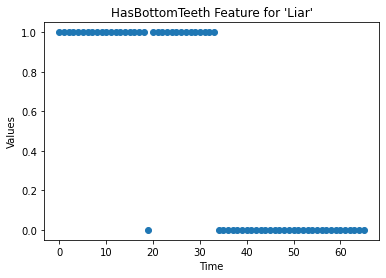

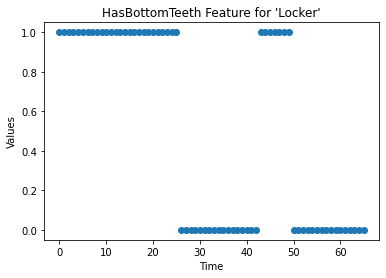

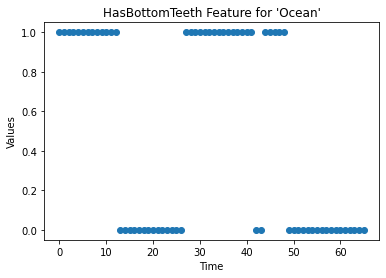

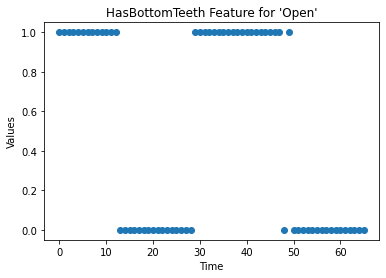

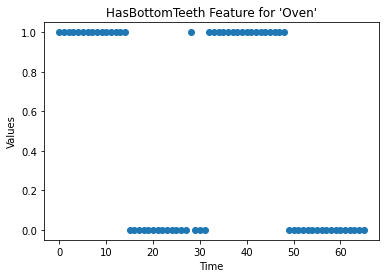

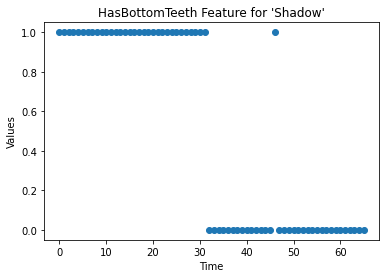

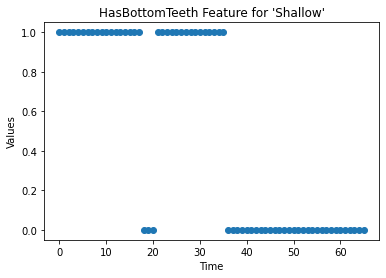

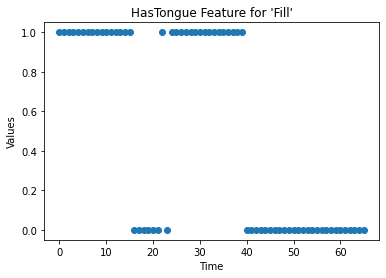

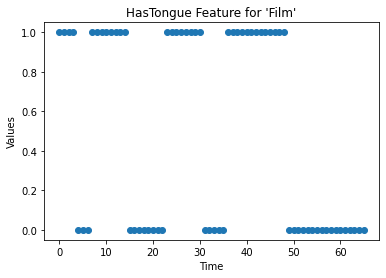

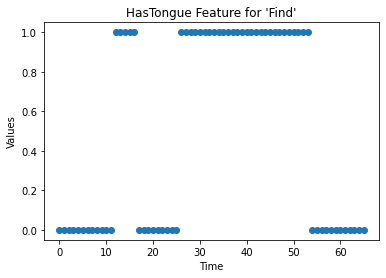

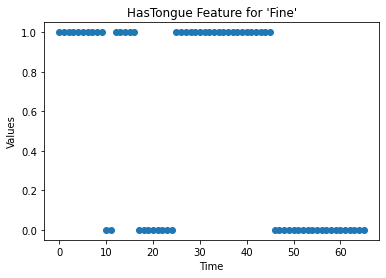

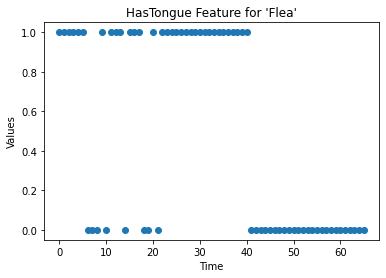

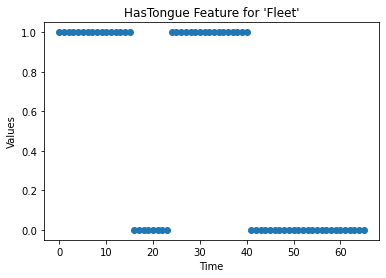

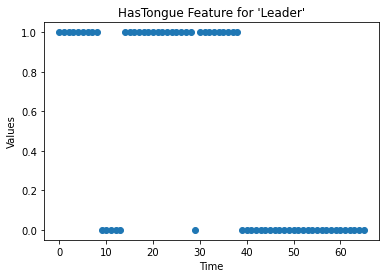

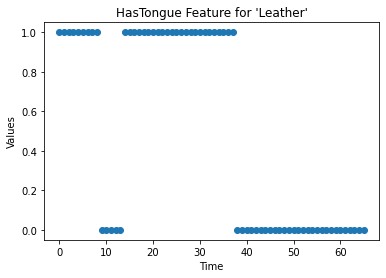

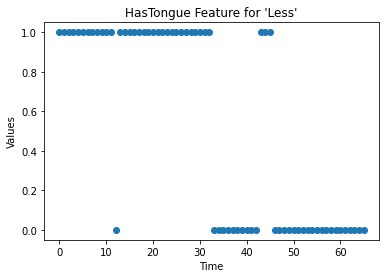

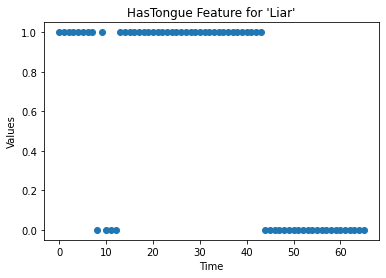

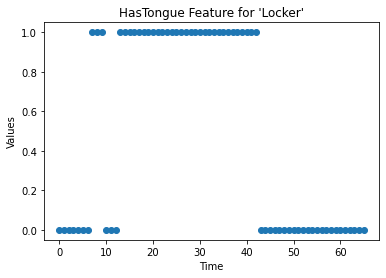

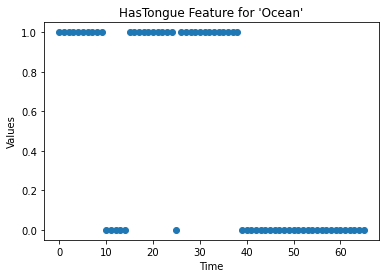

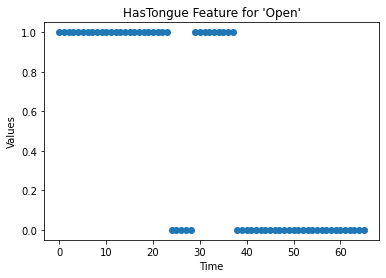

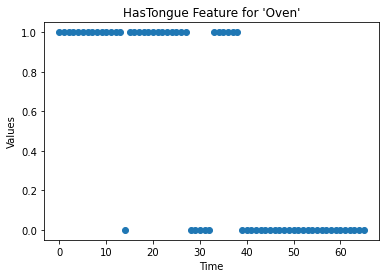

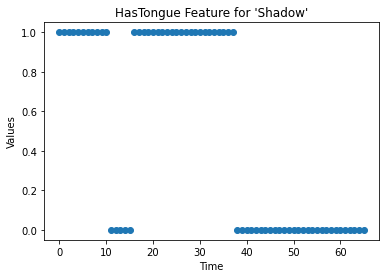

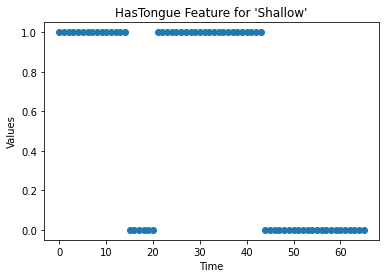

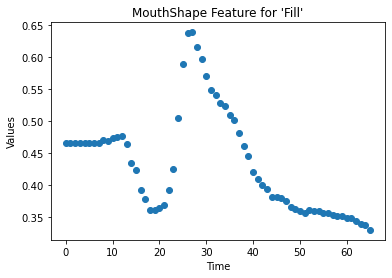

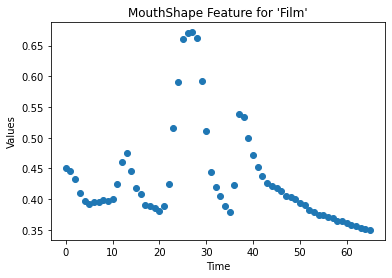

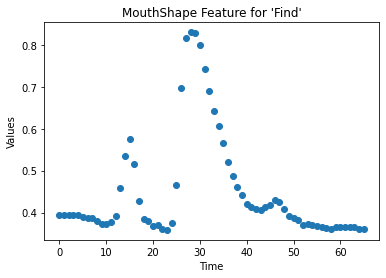

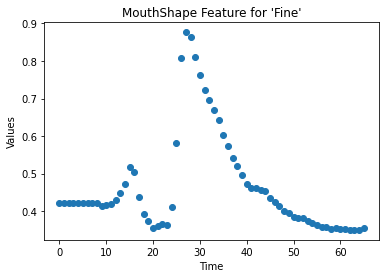

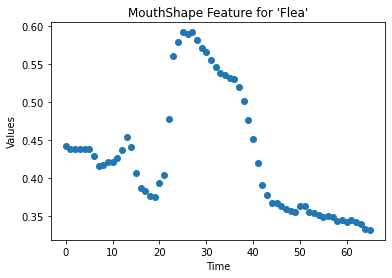

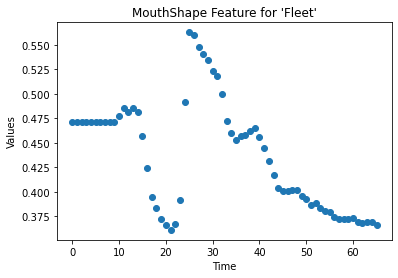

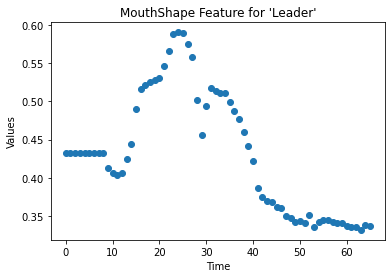

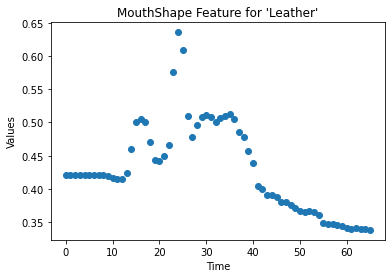

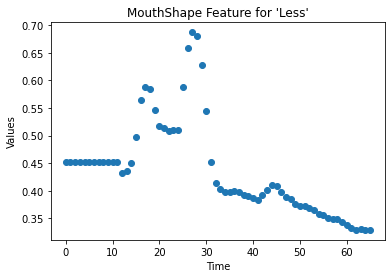

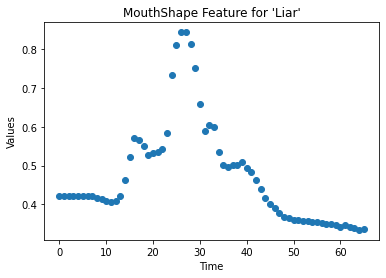

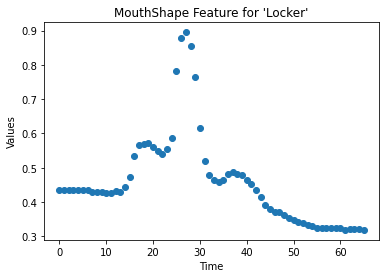

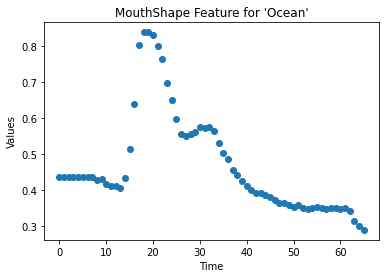

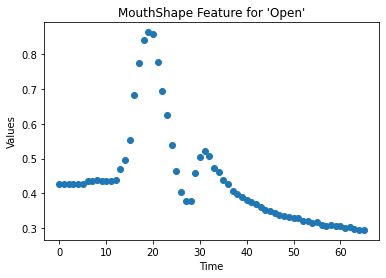

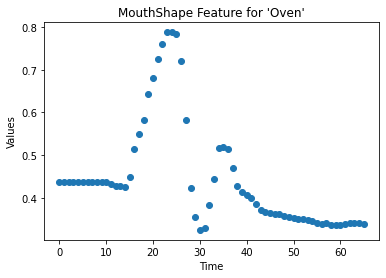

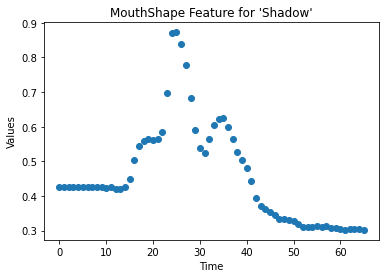

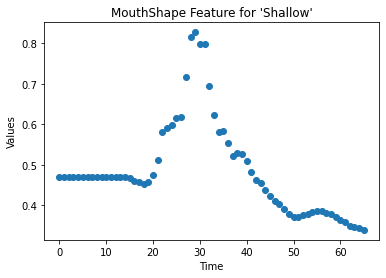

In [24]:
for col in df_new_features[0].columns:
    for i in range(len(df_new_features)):
        df = df_new_features[i]
        plt.figure()
        plt.scatter(range(len(df)), df[col])
        plt.title(f"{col} Feature for '{words[i]}'")
        plt.xlabel("Time")
        plt.ylabel("Values")
    

plt.show()

In [25]:
## TODO: create vectors according to threshold for thing (how to determine threshold?)

In [26]:
# get distributions to see whether use min-max scaling/normalization (0-1) or standardization (mean 0, std 1)

mouth_areas = np.zeros((len(df_new_features), len(df_new_features[0])))
for i, df in enumerate(df_new_features):
    mouth_areas[i,:] = df["MouthArea"]
    
mouth_areas = mouth_areas.reshape(-1)

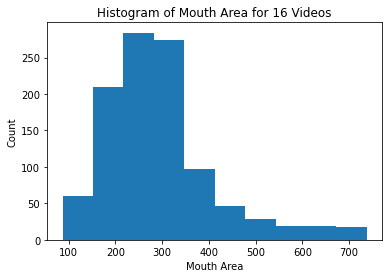

In [27]:
plt.hist(mouth_areas)
plt.title(f"Histogram of Mouth Area for {len(df_new_features)} Videos")
plt.xlabel("Mouth Area")
plt.ylabel("Count")
plt.show()

In [28]:
scaler = MinMaxScaler()
mouth_areas_scaled = np.zeros((len(df_new_features), len(df_new_features[0])))
for i, df in enumerate(df_new_features):
    mouth_areas_scaled[i,:] = df["MouthArea"]
    
mouth_areas_scaled = scaler.fit_transform(mouth_areas_scaled)
mouth_areas_scaled_flat = mouth_areas_scaled.reshape(-1)

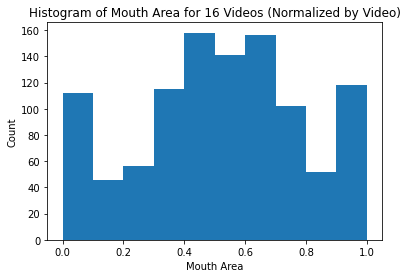

In [29]:
plt.hist(mouth_areas_scaled_flat)
plt.title(f"Histogram of Mouth Area for {len(df_new_features)} Videos (Normalized by Video)")
plt.xlabel("Mouth Area")
plt.ylabel("Count")
plt.show()

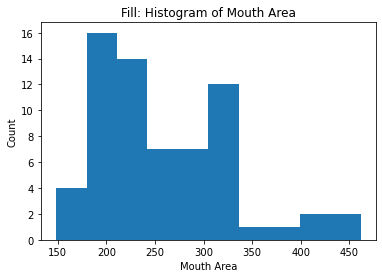

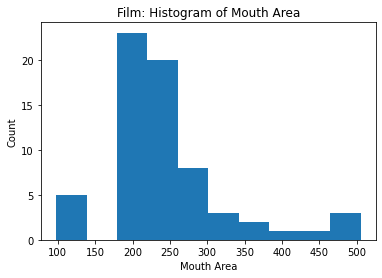

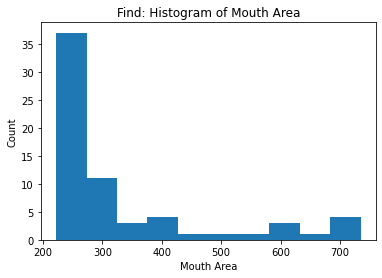

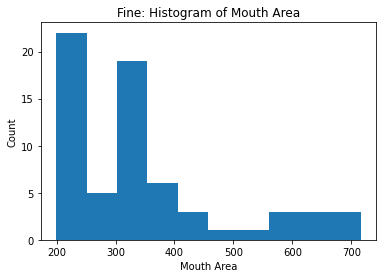

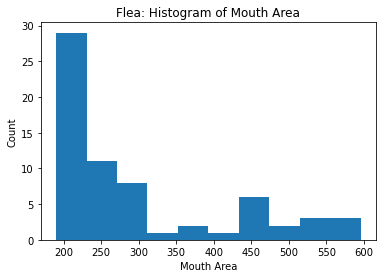

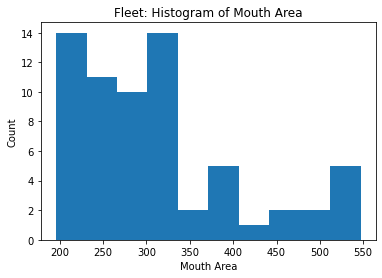

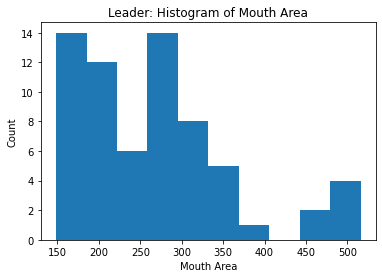

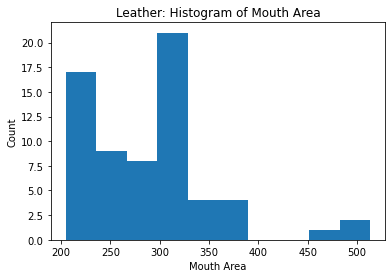

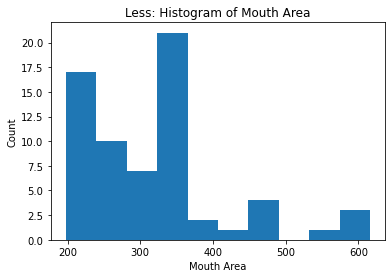

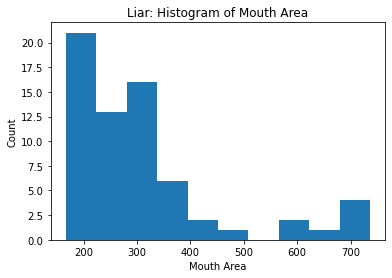

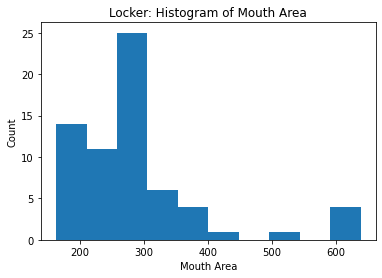

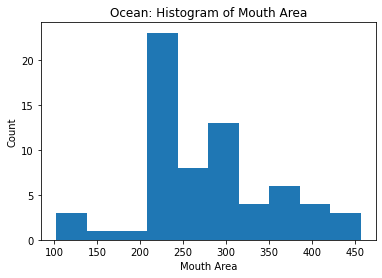

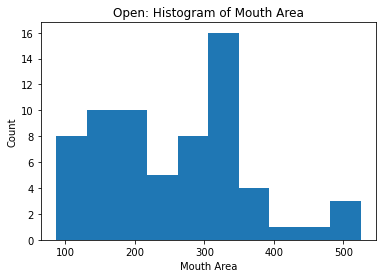

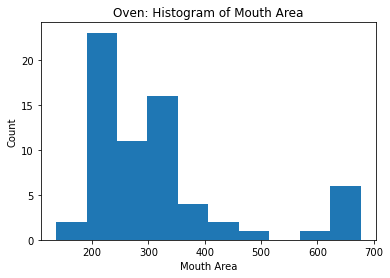

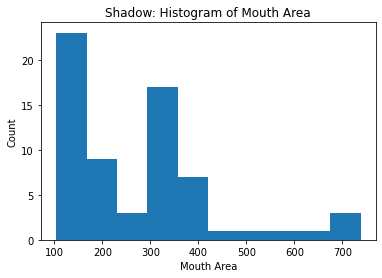

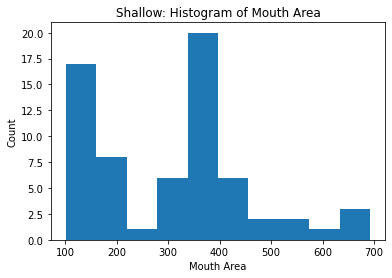

In [30]:
for i,df in enumerate(df_new_features):
    plt.figure()
    plt.hist(df["MouthArea"])
    plt.title(f"{words[i].capitalize()}: Histogram of Mouth Area")
    plt.xlabel("Mouth Area")
    plt.ylabel("Count")

plt.show()

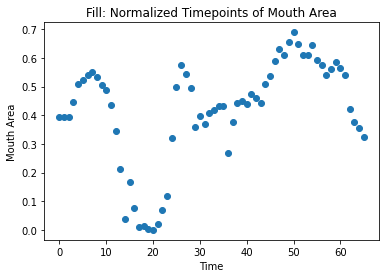

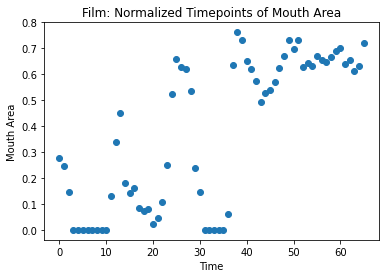

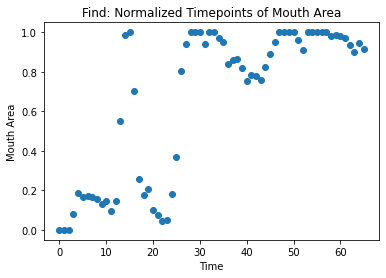

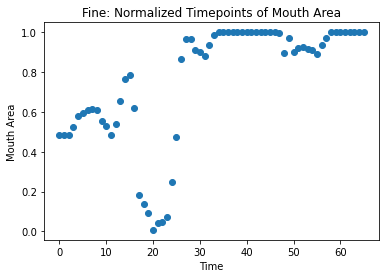

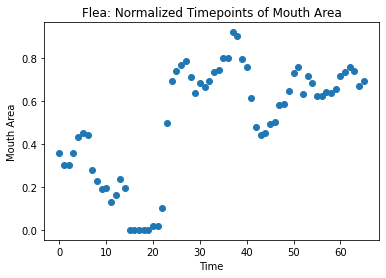

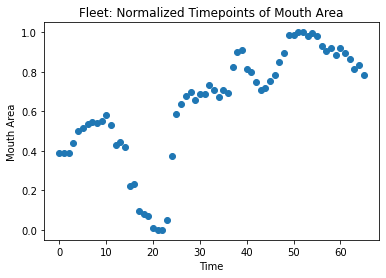

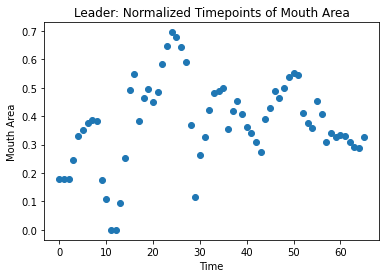

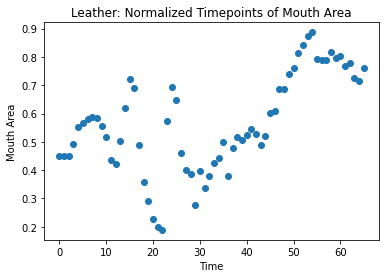

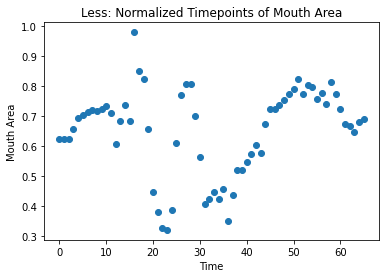

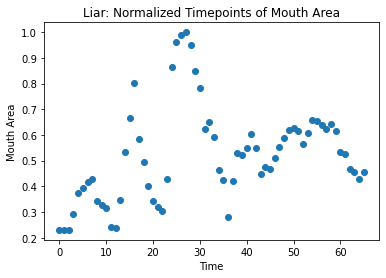

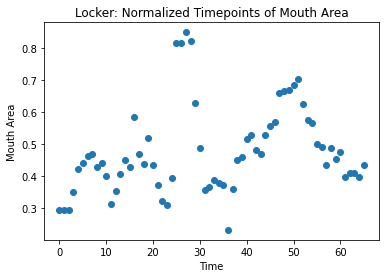

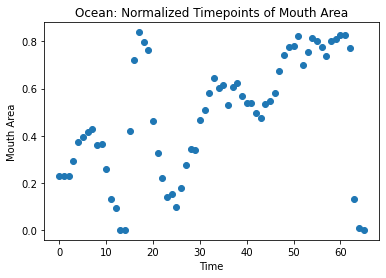

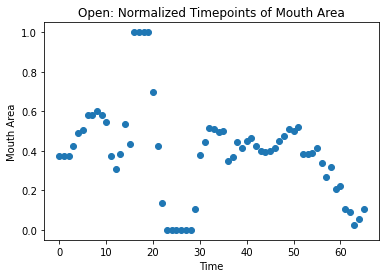

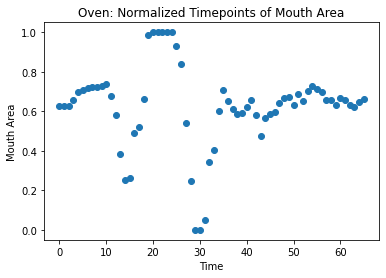

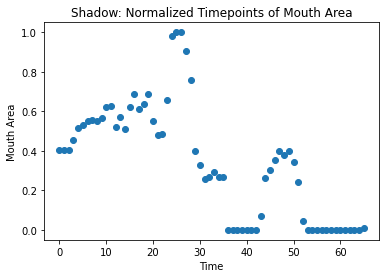

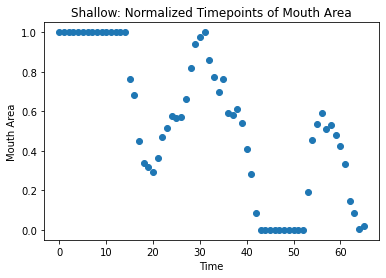

In [72]:
for i in range(len(df_new_features)):
    plt.figure()
    plt.scatter(range(len(df_new_features[0])), mouth_areas_scaled[i,:])
    plt.title(f"{words[i].capitalize()}: Normalized Timepoints of Mouth Area")
    plt.xlabel("Time")
    plt.ylabel("Mouth Area")

plt.show()

In [31]:
scaler = MinMaxScaler()
mouth_shapes_scaled = np.zeros((len(df_new_features), len(df_new_features[0])))
for i, df in enumerate(df_new_features):
    mouth_shapes_scaled[i,:] = df["MouthArea"]
    
mouth_shapes_scaled = scaler.fit_transform(mouth_shapes_scaled)
mouth_shapes_scaled_flat = mouth_shapes_scaled.reshape(-1)

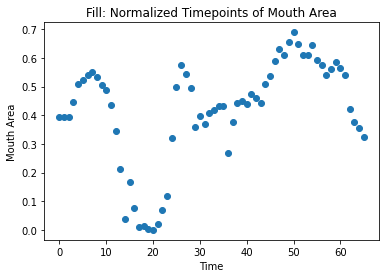

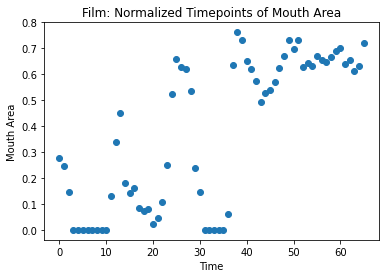

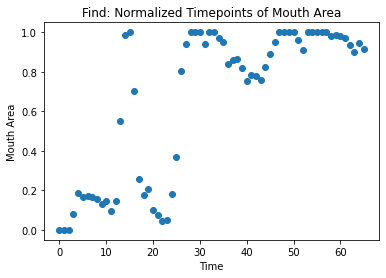

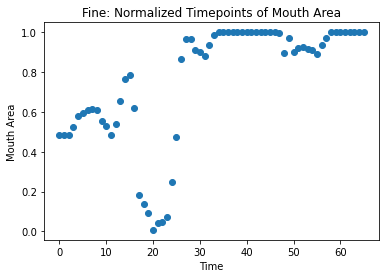

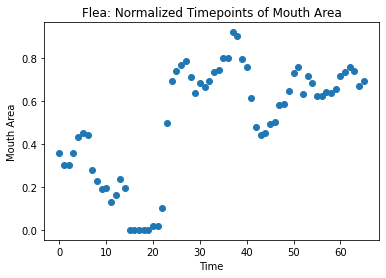

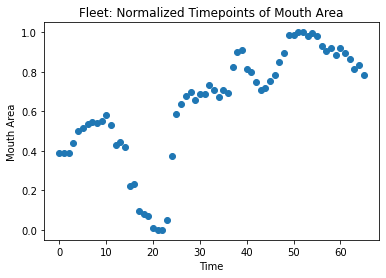

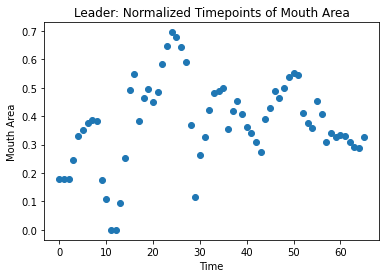

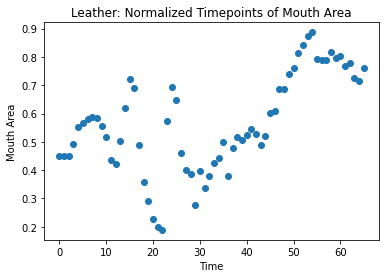

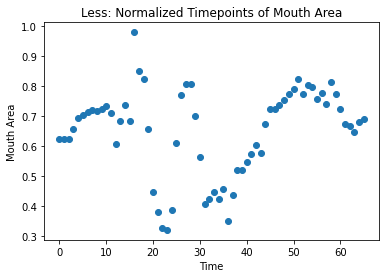

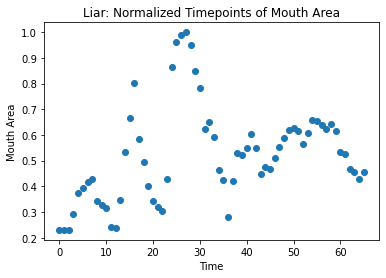

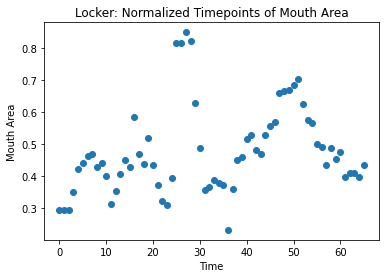

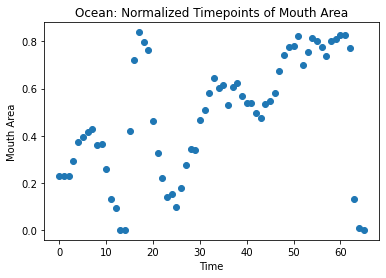

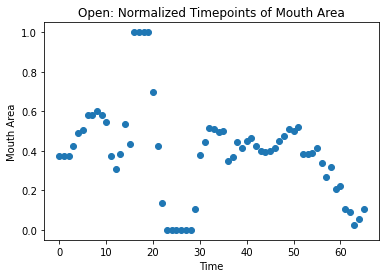

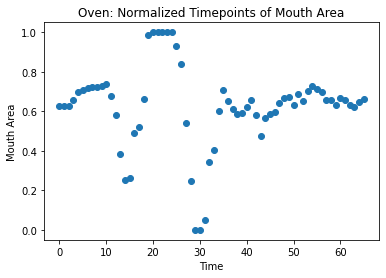

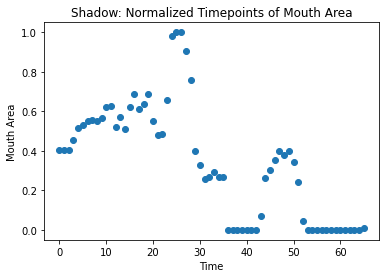

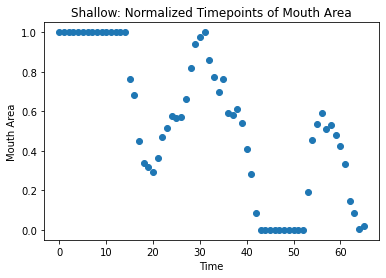

In [32]:
for i in range(len(df_new_features)):
    plt.figure()
    plt.scatter(range(len(df_new_features[0])), mouth_areas_scaled[i,:])
    plt.title(f"{words[i].capitalize()}: Normalized Timepoints of Mouth Area")
    plt.xlabel("Time")
    plt.ylabel("Mouth Area")

plt.show()

In [26]:
# run cross-correlations on each 
# TODO: need to have x_y and z as a separate thing... maybe put likelihoods by bodypart and then x y can be fine as is?

for i in range(len(df_videos)-1):
    assert df_videos[i].shape[0] == df_videos[i+1].shape[0], f'Checking {i} and {i+1}: {df_videos[i].shape} vs {df_videos[i+1].shape}'
    

# Features over time:
    # TODO: calculate mouth opening (area) [then it's independent of actual location in video space]
    # tongue present/absent (proba threshold)
    # top teeth present/absent
    # bottom teeth present/absent
    
    
# later on, prolly do distance between matrices ("average over time window" bc need to take acct time)
    